In [100]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import copy
import networkx as nx
from collections import Counter
import numpy as np
import json
import powerlaw


In [9]:
df_trec = pd.read_parquet("../data/Network_preparations_TREC.parquet")
df_ceur = pd.read_parquet("../data/Network_preparations_CEUR.parquet")
df_lncs = pd.read_parquet("../data/Network_preparations_LNCS.parquet")

# Calculate the Coverage gain by using GROBID

In [10]:
def calculate_coverage_gain_grobid(df):
    counter = 0
    for i, j in df.iterrows():
        if len(j["Countries"]) == 0 and len(j["grobid"]) == 0 :
            counter += 1
    cov_perc = (len(df) - counter) / len(df)
    return cov_perc
    

In [11]:
print(calculate_coverage_gain_grobid(df_trec))

0.8


In [ ]:
print(calculate_coverage_gain_grobid(df_ceur))

0.8299510146955913


In [13]:
print(calculate_coverage_gain_grobid(df_lncs))

0.9640816326530612


# Analysis of the German IR Community

In [14]:
df_trec["Proceeding"] = "TREC"
df_lncs["Proceeding"] = "LNCS"
df_ceur["Proceeding"] = "CEUR"

In [15]:
df_german = pd.concat([df_ceur, df_lncs, df_trec], axis=0).reset_index(drop=True)

In [16]:
# Manually created list of all variations of Germany occuring in the data

#concordance_list = ["Germany", 'GERMANY', "Germany, www"]
concordance_list = ["Germany", 'Germany, Germany', "Germany (", "GERMANY", "Germany [", "Germany, www", "Canada), UK) IAI (Germany" ]

In [17]:
# Filter documents by participating institutions from Germany 
german_participation = []
for i, j in df_german.iterrows():
    for k in j["Countries"]:
        if k[0] in concordance_list:
            if i not in german_participation:
                german_participation.append(i)
    for k in j["grobid"]:
        if k[0] in concordance_list:
            if i not in german_participation:
                german_participation.append(i)

In [18]:
df_german = df_german.loc[german_participation]

In [19]:
len(df_german)

560

In [20]:
# Create a complete list of all institutions mentioned regarding documents, where at least one German Institut participated

institutions = []
for i , j in df_german.iterrows():
    for k in j["Countries"]:
        if [k[1], k[0]] not in institutions:
            institutions.append([k[1], k[0]])
    for h in j["grobid"]:
        if [h[1], h[0]] not in institutions:
            institutions.append([h[1], h[0]])

In [21]:
len(institutions)

758

In [22]:
institutions

[['Chair Media Informatics', 'Germany'],
 ['Department of Electrical Engineering and Information Technology',
  'Germany'],
 ['Computer Vision Group', 'Germany'],
 ['Cologne University of Applied Sciences', 'Germany'],
 ['GESIS -Leibniz Institute for the Social Sciences', 'Germany'],
 ['TU Berlin', 'Germany'],
 ['University of Glasgow', 'UK'],
 ['TU Delft', 'The Netherlands'],
 ['Plista GmbH', 'Germany'],
 ['ContentWise R&D -Moviri', 'Italy'],
 ['Gravity R&D', 'Hungary'],
 ['Technische Universität Berlin', 'Germany'],
 ['DAI-Labor', 'Germany'],
 ['Agent Technologies in Business Applications and Telecommunication Group (AOT)',
  'Germany'],
 ['Agent Technologies in Business Applications and Telecommunication Group',
  'Germany'],
 ['University of the Aegean', 'Greece'],
 ['University of Innsbruck', 'Austria'],
 ['University of Antwerp', 'Belgium'],
 ['Bauhaus-Universität Weimar', 'Germany'],
 ['Autoritas Consulting.A', 'Spain'],
 ['PRHLT Research Center', 'Spain'],
 ['CLiPS -Computation

In [23]:
institutions = list(map(list, set(map(tuple, institutions))))

In [24]:
len(institutions)

758

In [25]:
german_institutes_list =[] 
for index, item in enumerate(institutions):
    if "germany" in item[1].lower():
        if item[0] not in german_institutes_list:
            german_institutes_list.append(item[0])


In [45]:
# Reading dictionary that contains all name variations of the given german institutes in order to unify the institute names

with open('../data/reassigning_institutes_dict.json', 'r') as json_file:
    inst_reassigment_dict = json.load(json_file)

In [46]:
# Reading dictionary that contains all name variations of the given authors that are associated with a german institutes in order to unify the author names

with open('../data/reassigning_authors_dict.json', 'r') as json_file:
    auth_reassigment_dict = json.load(json_file)

In [47]:
# Apply the concordance dicts to unify author names

def replace_in_nested_arrays(nested_arrays, replacement_dict):
    # Iterate over each array in the nested arrays
    for outer_array in nested_arrays:
        # Look through each element in the individual sub-array
        for i, element in enumerate(outer_array):
            for key, value_list in replacement_dict.items():
                # Check each key-value pair in the dictionary
                if element in value_list:
                    # Replace the matched element with the corresponding key
                    outer_array[i] = key
                    break

    return nested_arrays

# Apply the function to the DataFrame column
df_german['grobid_new'] = df_german['grobid'].apply(lambda x: replace_in_nested_arrays(copy.deepcopy(x), auth_reassigment_dict))
df_german['Countries_new'] = df_german['Countries'].apply(lambda x: replace_in_nested_arrays(copy.deepcopy(x), auth_reassigment_dict))

In [48]:
# Extract the german institutes from the DataFrame based on the concordance_list
german_institutes_full = []

for i, row in df_german.iterrows():
    german_institutes = []
    for sublist in row["Countries_new"]:
        if sublist[0] in concordance_list:
            if sublist[1] not in german_institutes:
                german_institutes.append(sublist[1])
    for sublist in row["grobid_new"]:
        if sublist[0] in concordance_list:
            if sublist[1] not in german_institutes:
                german_institutes.append(sublist[1])

    german_institutes_full.append(german_institutes)

In [49]:
df_german["German Institutes"] = german_institutes_full

In [ ]:
def transform_and_deduplicate(institute_list, replacement_dict):
    # Create a new list with replaced values
    transformed_list = [
        next((key for key, value_list in replacement_dict.items() if institute in value_list), institute)
        for institute in institute_list
    ]
    # Remove duplicates by converting the list to a set and back to a list
    return list(set(transformed_list))

# Apply the function to the column
df_german['Processed Institutes'] = df_german['German Institutes'].apply(lambda x: transform_and_deduplicate(x, inst_reassigment_dict))

               filename                                  German Institutes  \
5          16090069.pdf                          [Chair Media Informatics]   
45         16090481.pdf  [Department of Electrical Engineering and Info...   
58         16090591.pdf  [Cologne University of Applied Sciences, GESIS...   
59         16090593.pdf                           [TU Berlin, Plista GmbH]   
60         16090606.pdf         [Technische Universität Berlin, DAI-Labor]   
...                 ...                                                ...   
5689        Webis.D.pdf  [Martin Luther University Halle-Wittenberg, Le...   
5703      CiTIUS.HM.pdf  [University of Regensburg, Chair for Informati...   
5714  HSRM-LAVIS.DL.pdf         [RheinMain University of Applied Sciences]   
5722        mpii.DL.pdf                               [Max Planck Society]   
5763       webis.HM.pdf  [Bauhaus-Universität Weimar, Martin Luther Uni...   

                                   Processed Institutes  
5    

In [51]:
# Explode the Dataframe in order to cound the occurences of German Institutes

df_exploded1 = df_german.explode('Processed Institutes')
pivot_df = df_exploded1.groupby(['Processed Institutes', 'Proceeding']).size().unstack(fill_value=0)
pivot_df['Total'] = pivot_df.sum(axis=1)

In [52]:
pivot_df = pivot_df.sort_values("Total", ascending=False)[:20]

In [53]:
pivot_df

Proceeding,CEUR,LNCS,TREC,Total
Processed Institutes,,,,
University of Hildesheim,31,29,0,60
University of Hagen,23,20,0,43
MLT-Lab DFKI,20,16,2,38
Bauhaus-Universität Weimar,11,15,10,36
RWTH Computer Science Department,17,17,0,34
Universität Leipzig,19,13,1,33
Fraunhofer Society,21,4,6,31
Technische Unversität Chemnitz,12,13,0,25
Humboldt University Berlin,10,11,0,21


In [54]:
# Extract the participating authors per document

amount_authors = []
for i, j in df_german.iterrows():
    unique_authors = []
    for k in j["Countries_new"]:
        if k[2] not in unique_authors:
            unique_authors.append(k[2])
    for l in j["grobid_new"]:
        if l[2] not in unique_authors:
            unique_authors.append(l[2])
    
    amount_authors.append(len(unique_authors))

In [55]:
df_german["Amount Authors"] = amount_authors

In [56]:
df_german

,PubYear,CEUR Title,Volume,filename,Title,Section,Authors,url,ID,Countries,...,Subsection,DOI,Citation count,Authors & Affiliations,Classification,grobid_new,Countries_new,German Institutes,Processed Institutes,Amount Authors
5,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090069.pdf,Wrappers for Feature Subset Selection in CRF-b...,CLEFeHealth,"[Mike Ebersbach, Robert Herms, Christina Lohr,...",https://ceur-ws.org/Vol-1609/16090069.pdf,ceur_1025,[],...,NaN,NaN,NaN,NaN,NaN,"[[Germany, Chair Media Informatics, Mike Ebers...",[],[Chair Media Informatics],[Chair Media Informatics],4
45,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090481.pdf,SeaCLEF 2016: Object Proposal Classification f...,LifeCLEF,"[Jonas Jäger, Erik Rodner, Joachim Denzler, Vi...",https://ceur-ws.org/Vol-1609/16090481.pdf,ceur_1065,[],...,NaN,NaN,NaN,NaN,NaN,"[[Germany, Department of Electrical Engineerin...",[],[Department of Electrical Engineering and Info...,[Department of Electrical Engineering and Info...,5
58,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090591.pdf,Ideas for a Standard LL4IR Extension - Living ...,LL4IR & NewsREEL: New Ideas,"[Philipp Schaer, Narges Tavakolpoursaleh]",https://ceur-ws.org/Vol-1609/16090591.pdf,ceur_1079,[],...,NaN,NaN,NaN,NaN,NaN,"[[Germany, Cologne University of Applied Scien...",[],"[Cologne University of Applied Sciences, GESIS...",[GESIS - Leibniz-Institute for the Social Scie...,1
59,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090593.pdf,CLEF NewsREEL 2016: Comparing Multi-dimensiona...,News Recommendation Evaluation Lab (NEWSREEL),"[Benjamin Kille, Andreas Lommatzsch, Frank Hop...",https://ceur-ws.org/Vol-1609/16090593.pdf,ceur_1080,[],...,NaN,NaN,NaN,NaN,NaN,"[[Germany, TU Berlin, Benjamin Kille], [German...",[],"[TU Berlin, Plista GmbH]","[Technische Universität Berlin, Plista GmbH]",8
60,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090606.pdf,Development of a News Recommender System based...,News Recommendation Evaluation Lab (NEWSREEL),"[Alexandru Ciobanu, Andreas Lommatzsch]",https://ceur-ws.org/Vol-1609/16090606.pdf,ceur_1081,[],...,NaN,NaN,NaN,NaN,NaN,"[[Germany, Technische Universität Berlin, Alex...",[],"[Technische Universität Berlin, DAI-Labor]","[DAI-Labor, Technische Universität Berlin]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,2019,NaN,NaN,Webis.D.pdf,Webis at TREC 2019: Decision Track.,Participant Papers,"[Alexander Bondarenko, Maik Fröbe, Vaibhav Kas...",https://trec.nist.gov/pubs/trec28/papers/Webis...,trec_1745,"[[Germany, Martin Luther University Halle-Witt...",...,NaN,NaN,NaN,NaN,Participant,[],"[[Germany, Martin Luther University Halle-Witt...","[Martin Luther University Halle-Wittenberg, Le...","[Bauhaus-Universität Weimar, Martin-Luther-Uni...",6
5703,2020,NaN,NaN,CiTIUS.HM.pdf,CiTIUS at the TREC 2020 Health Misinformation ...,Participant Papers,"[Marcos Fernández-Pichel, David E. Losada, Jua...",https://trec.nist.gov/pubs/trec29/papers/CiTIU...,trec_1761,"[[Spain, Universidade de Santiago de Compostel...",...,NaN,NaN,NaN,NaN,Participant,"[[Spain, Centro Singular de Investigación en T...","[[Spain, Universidade de Santiago de Compostel...","[University of Regensburg, Chair for Informati...","[University of Regensburg, Chair for Informati...",5
5714,2020,NaN,NaN,HSRM-LAVIS.DL.pdf,HSRM-LAVIS at TREC 2020 Deep Learning Track: N...,Participant Papers,"[Marco Wrzalik, Dirk Krechel]",https://trec.nist.gov/pubs/trec29/papers/HSRM-...,trec_1773,"[[Germany, RheinMain University of Applied Sci...",...,NaN,NaN,NaN,NaN,Participant,[],"[[Germany, RheinMain University of Applied Sci...",[RheinMain University of Applied Sciences],[RheinMain University of Applied Sciences],2
5722,2020,NaN,NaN,mpii.DL.pdf,MPII at the TREC 2020 Deep Learning Track.,Participant Papers,"[Canjia Li, Andrew Yates]",https://trec.nist.gov/pubs/trec29/papers/mpii....,trec_1782,"[[

In [57]:
# Explode by German institutes again to get the German Institutes in separat rows

df_exploded = df_german.explode("Processed Institutes")

In [58]:
df_exploded

,PubYear,CEUR Title,Volume,filename,Title,Section,Authors,url,ID,Countries,...,Subsection,DOI,Citation count,Authors & Affiliations,Classification,grobid_new,Countries_new,German Institutes,Processed Institutes,Amount Authors
5,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090069.pdf,Wrappers for Feature Subset Selection in CRF-b...,CLEFeHealth,"[Mike Ebersbach, Robert Herms, Christina Lohr,...",https://ceur-ws.org/Vol-1609/16090069.pdf,ceur_1025,[],...,NaN,NaN,NaN,NaN,NaN,"[[Germany, Chair Media Informatics, Mike Ebers...",[],[Chair Media Informatics],Chair Media Informatics,4
45,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090481.pdf,SeaCLEF 2016: Object Proposal Classification f...,LifeCLEF,"[Jonas Jäger, Erik Rodner, Joachim Denzler, Vi...",https://ceur-ws.org/Vol-1609/16090481.pdf,ceur_1065,[],...,NaN,NaN,NaN,NaN,NaN,"[[Germany, Department of Electrical Engineerin...",[],[Department of Electrical Engineering and Info...,Department of Electrical Engineering and Infor...,5
45,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090481.pdf,SeaCLEF 2016: Object Proposal Classification f...,LifeCLEF,"[Jonas Jäger, Erik Rodner, Joachim Denzler, Vi...",https://ceur-ws.org/Vol-1609/16090481.pdf,ceur_1065,[],...,NaN,NaN,NaN,NaN,NaN,"[[Germany, Department of Electrical Engineerin...",[],[Department of Electrical Engineering and Info...,Computer Vision Group,5
58,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090591.pdf,Ideas for a Standard LL4IR Extension - Living ...,LL4IR & NewsREEL: New Ideas,"[Philipp Schaer, Narges Tavakolpoursaleh]",https://ceur-ws.org/Vol-1609/16090591.pdf,ceur_1079,[],...,NaN,NaN,NaN,NaN,NaN,"[[Germany, Cologne University of Applied Scien...",[],"[Cologne University of Applied Sciences, GESIS...",GESIS - Leibniz-Institute for the Social Sciences,1
58,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090591.pdf,Ideas for a Standard LL4IR Extension - Living ...,LL4IR & NewsREEL: New Ideas,"[Philipp Schaer, Narges Tavakolpoursaleh]",https://ceur-ws.org/Vol-1609/16090591.pdf,ceur_1079,[],...,NaN,NaN,NaN,NaN,NaN,"[[Germany, Cologne University of Applied Scien...",[],"[Cologne University of Applied Sciences, GESIS...",TH Köln -University of Applied Sciences,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5703,2020,NaN,NaN,CiTIUS.HM.pdf,CiTIUS at the TREC 2020 Health Misinformation ...,Participant Papers,"[Marcos Fernández-Pichel, David E. Losada, Jua...",https://trec.nist.gov/pubs/trec29/papers/CiTIU...,trec_1761,"[[Spain, Universidade de Santiago de Compostel...",...,NaN,NaN,NaN,NaN,Participant,"[[Spain, Centro Singular de Investigación en T...","[[Spain, Universidade de Santiago de Compostel...","[University of Regensburg, Chair for Informati...",Chair for Information Science,5
5714,2020,NaN,NaN,HSRM-LAVIS.DL.pdf,HSRM-LAVIS at TREC 2020 Deep Learning Track: N...,Participant Papers,"[Marco Wrzalik, Dirk Krechel]",https://trec.nist.gov/pubs/trec29/papers/HSRM-...,trec_1773,"[[Germany, RheinMain University of Applied Sci...",...,NaN,NaN,NaN,NaN,Participant,[],"[[Germany, RheinMain University of Applied Sci...",[RheinMain University of Applied Sciences],RheinMain University of Applied Sciences,2
5722,2020,NaN,NaN,mpii.DL.pdf,MPII at the TREC 2020 Deep Learning Track.,Participant Papers,"[Canjia Li, Andrew Yates]",https://trec.nist.gov/pubs/trec29/papers/mpii....,trec_1782,"[[China, Chinese Academy of Sciences, Canjia L...",...,NaN,NaN,NaN,NaN,Participant,[],"[[China, Chinese Academy of Sciences, Canjia L...",[Max Planck Society],Max Planck Society,2
5763,2020,NaN,NaN,webis.HM.pdf,Webis at TREC 2020: Health Misinformation Trac...,Participant Papers,"[Janek Bevendorff, Michael Völske, Benno Stein...",https://trec.nist.gov/pubs/trec29/papers/webis...,trec_1825,"[[Germany, Bauhaus-Universität Weimar, Janek B...",...,NaN,NaN,NaN,NaN,Participant,[],"[[Germany, Bauhaus-Universität Weimar, Jane

In [59]:
# Calculate the minimum, maximum and average amount of authors per german institute based on the extracted authors 

stats_df = df_exploded.groupby('Processed Institutes').agg(
    min_amount=('Amount Authors', 'min'),
    max_amount=('Amount Authors', 'max'),
    avg_amount=('Amount Authors', 'mean')
).reset_index()

In [60]:
stats_df = stats_df[stats_df["Processed Institutes"].isin(list(pivot_df.index))]

In [61]:
# Sort German Insitutes descending based on the Top contributing Institutes
stats_df = stats_df.set_index('Processed Institutes').reindex(list(pivot_df.index)).reset_index()

In [55]:
stats_df

,Processed Institutes,min_amount,max_amount,avg_amount
0,University of Hildesheim,1,18,4.483333
1,University of Hagen,1,7,1.883721
2,MLT-Lab DFKI,1,18,4.552632
3,Web Technology & Information Systems Bauhaus,2,17,7.567568
4,Information Processing and Ergonomics FKIE,1,8,2.685714
5,RWTH Computer Science Department,1,17,4.588235
6,Universität Leipzig,1,17,6.727273
7,Technische Unversität Chemnitz,1,11,3.520000
8,Humboldt University Berlin,1,10,4.619048
9,GESIS - Leibniz-Institute for the Social Sciences,1,16,3.950000


# Betweeness centrality Preparations (for Authors)

In [63]:
# Create a list of all participating authors within the documents that have at least one german participating institute

authors_complete = []
for i, j in df_german.iterrows():
    authors = []
    for k in j["Countries_new"]:
        if k[2] not in authors:
            authors.append(k[2])
    for k in j["grobid_new"]:
        if k[2] not in authors:
            authors.append(k[2])
    authors_complete.append(authors)

In [64]:
df_german["authors_all"] = authors_complete

In [ ]:
# Create a list of all authors within the documents that work for a german institute

german_authors_complete = []
for i, row in df_german.iterrows():
    for k in row["Countries_new"]:
        if k[0] in concordance_list:
            if k[2] not in german_authors_complete:
                german_authors_complete.append(k[2])
    for k in row["grobid_new"]:
        if k[0] in concordance_list:
            if k[2] not in german_authors_complete:
                german_authors_complete.append(k[2])      

In [70]:
# Manually removing misclassified authors manually for the Top 15, be aware that outside the Top 15 there still might be misclassified authors
german_authors_complete.remove("Petya Osenova")
german_authors_complete.remove("Giorgio Maria Di Nunzio")

In [71]:
# Filter empty string 

german_authors_complete = [author for author in german_authors_complete if author.strip()]

In [72]:
# Create co-authorship graph for all documents with participating german institutes

G = nx.DiGraph()
for paper in authors_complete:
    for i, author1 in enumerate(paper):
        for author2 in paper[i+1:]:
            G.add_edge(author1, author2)

In [73]:
# Calculate the betweeness centrality for the graph

betweenness_centrality = nx.betweenness_centrality(G)

node_centrality_pairs = []
for node, centrality in betweenness_centrality.items():
    node_centrality_pairs.append([node, centrality])


In [74]:
df_betweeness  = pd.DataFrame(node_centrality_pairs, columns=["Authors", "Betweeness"]).sort_values("Betweeness", ascending=False)

In [75]:
# Filter out all authors, which are not working in a german institute

df_betweeness = df_betweeness[df_betweeness["Authors"].isin(german_authors_complete)].sort_values("Betweeness", ascending=False)

In [76]:
df_betweeness.head(15)

,Authors,Betweeness
57,Thomas Mandl,0.074677
29,Benno Stein,0.036774
61,Vivien Petras,0.036245
111,Christoph Friedrich,0.022167
205,Diana Santos,0.020045
66,Christa Womser_Hacker,0.014107
107,Obioma Pelka,0.009408
30,Martin Potthast,0.008438
187,Bogdan Sacaleanu,0.007528
3,Maximilian Eibl,0.007440


In [77]:
# Calculating the amount of papers contributed to the proceedings by an author

amount_papers = []
for i in df_betweeness["Authors"]:
    counter_trec = 0
    counter_lncs = 0
    counter_ceur = 0
    
    for l,j in df_german.iterrows():
        if i in j["authors_all"]:
            if j["Proceeding"] == "TREC":
                counter_trec += 1
            elif j["Proceeding"] == "LNCS":
                counter_lncs += 1
            elif j["Proceeding"] == "CEUR":
                counter_ceur += 1           
    amount_papers.append([i, counter_trec, counter_lncs, counter_ceur, counter_trec + counter_lncs + counter_ceur])


In [79]:
df_works = pd.DataFrame(amount_papers, columns=["Authors", "# TREC", "# LNCS", "# CEUR", "Total" ])

In [80]:
df_merge = pd.merge(df_betweeness, df_works, how="inner", left_on= "Authors", right_on = "Authors")

In [81]:
df_merge.head(15)

,Authors,Betweeness,# TREC,# LNCS,# CEUR,Total
0,Thomas Mandl,0.074677,0,27,30,57
1,Benno Stein,0.036774,9,14,18,41
2,Vivien Petras,0.036245,0,8,5,13
3,Christoph Friedrich,0.022167,2,6,12,20
4,Diana Santos,0.020045,0,5,4,9
5,Christa Womser_Hacker,0.014107,0,16,17,33
6,Obioma Pelka,0.009408,0,3,6,9
7,Martin Potthast,0.008438,1,14,16,31
8,Bogdan Sacaleanu,0.007528,0,9,9,18
9,Maximilian Eibl,0.007440,0,12,21,33


In [84]:
# Extract author names for gathering their related institutes in the next step
authors_german_institutes = df_merge.head(15)["Authors"].tolist()

In [85]:
# Dictionary zur Speicherung der Zuordnungen
author_to_value = {}

for index, row in df_german.iterrows():
    for country_list in row['Countries_new']:
        third_value = country_list[2]
        second_value = country_list[1]
        
        if third_value in authors_german_institutes:
            author_to_value[third_value] = second_value
    for country_list in row['grobid_new']:
        third_value = country_list[2]
        second_value = country_list[1]
        
        if third_value in authors_german_institutes:
            author_to_value[third_value] = second_value

print(author_to_value)

{'Maximilian Eibl': 'Technische Universität Chemnitz', 'Benno Stein': 'Bauhaus-Universität Weimar', 'Martin Potthast': 'Bauhaus-Universität Weimar', 'Thomas Mandl': 'Information Science', 'Vivien Petras': 'Berlin School of Library and Information Science', 'Christa Womser_Hacker': 'Information Science', 'Obioma Pelka': 'University of Applied Sciences and Arts Dortmund', 'Christoph Friedrich': 'Science and Arts Dortmund Department of Computer Science', 'Matthias Hagen': 'Martin Luther University Halle-Wittenberg', 'Thomas Deselaers': 'RWTH Aachen University', 'Bogdan Sacaleanu': 'LT-Lab', 'Diana Santos': 'SINTEF', 'Stefan Kahl': 'Chemnitz University of Technology', 'Christina Unger': 'CITEC', 'Bayzidul Islam': 'Technische Universität Darmstadt'}


In [86]:
author_to_value

{'Maximilian Eibl': 'Technische Universität Chemnitz',
 'Benno Stein': 'Bauhaus-Universität Weimar',
 'Martin Potthast': 'Bauhaus-Universität Weimar',
 'Thomas Mandl': 'Information Science',
 'Vivien Petras': 'Berlin School of Library and Information Science',
 'Christa Womser_Hacker': 'Information Science',
 'Obioma Pelka': 'University of Applied Sciences and Arts Dortmund',
 'Christoph Friedrich': 'Science and Arts Dortmund Department of Computer Science',
 'Matthias Hagen': 'Martin Luther University Halle-Wittenberg',
 'Thomas Deselaers': 'RWTH Aachen University',
 'Bogdan Sacaleanu': 'LT-Lab',
 'Diana Santos': 'SINTEF',
 'Stefan Kahl': 'Chemnitz University of Technology',
 'Christina Unger': 'CITEC',
 'Bayzidul Islam': 'Technische Universität Darmstadt'}

In [87]:
# Extract the german authors (authors that were working for a german institute) for every document
german_authors_complete_2 = []

names_to_filter = ["Petya Osenova", "Giorgio Maria Di Nunzio"] 

for i, row in df_german.iterrows():
    authors = []
    for k in row["Countries_new"]:
        if k[0] in concordance_list:
            if k[2] not in authors and k[2] not in names_to_filter :
                authors.append(k[2])
    for k in row["grobid_new"]:
        if k[0] in concordance_list:
            if k[2] not in authors and k[2] not in names_to_filter:
                authors.append(k[2])
    german_authors_complete_2.append(authors)

print(len(german_authors_complete_2))

560


In [88]:
german_authors_complete_2

[['Mike Ebersbach', 'Robert Herms', 'Christina Lohr', 'Maximilian Eibl'],
 ['Jonas Jäger',
  'Erik Rodner',
  'Joachim Denzler',
  'Viviane Wolff',
  'Klaus Fricke_Neuderth'],
 [' '],
 ['Benjamin Kille', 'Andreas Lommatzsch', 'Jonas Seiler', 'Torben Brodt'],
 ['Alexandru Ciobanu', 'Andreas Lommatzsch'],
 ['Jaschar Domann', 'Jens Meiners', 'Lea Helmers', 'Andreas Lommatzsch'],
 ['Andreas Lommatzsch',
  'Niels Johannes',
  'Jens Meiners',
  'Lea Helmers',
  'Jaschar Domann'],
 ['Patrick Probst', 'Andreas Lommatzsch'],
 ['Jing Yuan', 'Andreas Lommatzsch', 'Benjamin Kille'],
 ['Benno Stein', 'Martin Potthast'],
 ['Martin Potthast', 'Benno Stein'],
 ['Ivan Bilan', 'Desislava Zhekova'],
 ['Matthias Liebeck', 'Pashutan Modaresi', 'Stefan Conrad'],
 ['Pashutan Modaresi', 'Matthias Liebeck', 'Stefan Conrad'],
 ['Maria Gäde'],
 ['Stefanie Nowak'],
 ['Olivier Pauly', 'Diana Mateus', 'Nassir Navab'],
 ['Andreas Nürnberger'],
 ['Philipp Sorg', 'Philipp Cimiano', 'Antje Schultz', 'Sergej Sizov'],
 [

In [89]:
df_german["German Authors all"] = german_authors_complete_2

In [90]:
df_german

,PubYear,CEUR Title,Volume,filename,Title,Section,Authors,url,ID,Countries,...,Citation count,Authors & Affiliations,Classification,grobid_new,Countries_new,German Institutes,Processed Institutes,Amount Authors,authors_all,German Authors all
5,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090069.pdf,Wrappers for Feature Subset Selection in CRF-b...,CLEFeHealth,"[Mike Ebersbach, Robert Herms, Christina Lohr,...",https://ceur-ws.org/Vol-1609/16090069.pdf,ceur_1025,[],...,NaN,NaN,NaN,"[[Germany, Chair Media Informatics, Mike Ebers...",[],[Chair Media Informatics],[Chair Media Informatics],4,"[Mike Ebersbach, Robert Herms, Christina Lohr,...","[Mike Ebersbach, Robert Herms, Christina Lohr,..."
45,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090481.pdf,SeaCLEF 2016: Object Proposal Classification f...,LifeCLEF,"[Jonas Jäger, Erik Rodner, Joachim Denzler, Vi...",https://ceur-ws.org/Vol-1609/16090481.pdf,ceur_1065,[],...,NaN,NaN,NaN,"[[Germany, Department of Electrical Engineerin...",[],[Department of Electrical Engineering and Info...,[Department of Electrical Engineering and Info...,5,"[Jonas Jäger, Erik Rodner, Joachim Denzler, Vi...","[Jonas Jäger, Erik Rodner, Joachim Denzler, Vi..."
58,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090591.pdf,Ideas for a Standard LL4IR Extension - Living ...,LL4IR & NewsREEL: New Ideas,"[Philipp Schaer, Narges Tavakolpoursaleh]",https://ceur-ws.org/Vol-1609/16090591.pdf,ceur_1079,[],...,NaN,NaN,NaN,"[[Germany, Cologne University of Applied Scien...",[],"[Cologne University of Applied Sciences, GESIS...",[GESIS - Leibniz-Institute for the Social Scie...,1,[ ],[ ]
59,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090593.pdf,CLEF NewsREEL 2016: Comparing Multi-dimensiona...,News Recommendation Evaluation Lab (NEWSREEL),"[Benjamin Kille, Andreas Lommatzsch, Frank Hop...",https://ceur-ws.org/Vol-1609/16090593.pdf,ceur_1080,[],...,NaN,NaN,NaN,"[[Germany, TU Berlin, Benjamin Kille], [German...",[],"[TU Berlin, Plista GmbH]","[Technische Universität Berlin, Plista GmbH]",8,"[Benjamin Kille, Andreas Lommatzsch, Frank Hop...","[Benjamin Kille, Andreas Lommatzsch, Jonas Sei..."
60,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090606.pdf,Development of a News Recommender System based...,News Recommendation Evaluation Lab (NEWSREEL),"[Alexandru Ciobanu, Andreas Lommatzsch]",https://ceur-ws.org/Vol-1609/16090606.pdf,ceur_1081,[],...,NaN,NaN,NaN,"[[Germany, Technische Universität Berlin, Alex...",[],"[Technische Universität Berlin, DAI-Labor]","[DAI-Labor, Technische Universität Berlin]",2,"[Alexandru Ciobanu, Andreas Lommatzsch]","[Alexandru Ciobanu, Andreas Lommatzsch]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,2019,NaN,NaN,Webis.D.pdf,Webis at TREC 2019: Decision Track.,Participant Papers,"[Alexander Bondarenko, Maik Fröbe, Vaibhav Kas...",https://trec.nist.gov/pubs/trec28/papers/Webis...,trec_1745,"[[Germany, Martin Luther University Halle-Witt...",...,NaN,NaN,Participant,[],"[[Germany, Martin Luther University Halle-Witt...","[Martin Luther University Halle-Wittenberg, Le...","[Bauhaus-Universität Weimar, Martin-Luther-Uni...",6,"[Alexander Bondarenko, Maik Fröbe, Vaibhav Kas...","[Alexander Bondarenko, Maik Fröbe, Vaibhav Kas..."
5703,2020,NaN,NaN,CiTIUS.HM.pdf,CiTIUS at the TREC 2020 Health Misinformation ...,Participant Papers,"[Marcos Fernández-Pichel, David E. Losada, Jua...",https://trec.nist.gov/pubs/trec29/papers/CiTIU...,trec_1761,"[[Spain, Universidade de Santiago de Compostel...",...,NaN,NaN,Participant,"[[Spain, Centro Singular de Investigación en T...","[[Spain, Universidade de Santiago de Compostel...","[University of Regensburg, Chair for Informati...","[University of Regensburg, Chair for Informati...",5,"[Marcos Fernández_Pichel, David E. Losada, Jua...","[David Elsweiler, ]"
5714,2020,NaN,NaN,HSRM-LAVIS.DL.pdf,HSRM-LAVIS at TREC 2020 Deep 

In [91]:
# Exploding the DataFrame to count the total contributions of the author
exploded_df = df_german.explode('German Authors all')


In [92]:
# Count the amount of occurences of the german authors

pub_counts = exploded_df['German Authors all'].value_counts()


In [93]:
pub_counts

German Authors all
Thomas Mandl             57
Benno Stein              41
Christa Womser_Hacker    33
Maximilian Eibl          33
Martin Potthast          31
                         ..
Lukas Christ              1
Maximilian Bundesmann     1
Anna Triebel              1
Tilmann Sager             1
Sebastian Günther         1
Name: count, Length: 525, dtype: int64

In [94]:
# Group up and count the amount of authors that contributed the same amount of publications
frequency_distribution = Counter(pub_counts)

In [95]:
frequency_distribution

Counter({1: 307,
         2: 98,
         3: 30,
         4: 25,
         6: 14,
         5: 14,
         7: 5,
         9: 4,
         8: 4,
         21: 3,
         18: 3,
         33: 2,
         20: 2,
         17: 2,
         14: 2,
         12: 2,
         57: 1,
         41: 1,
         31: 1,
         22: 1,
         19: 1,
         13: 1,
         11: 1,
         10: 1})

In [96]:
n = np.array(list(frequency_distribution.keys()))
observed = np.array(list(frequency_distribution.values()))

In [97]:
observed

array([  1,   1,   2,   1,   1,   3,   2,   1,   3,   2,   2,   1,   2,
         1,   1,   4,   4,   5,  14,  14,  25,  30,  98, 307])

In [98]:
# Calculate the expected Lotka distribution based on the given data

f_1 = observed[np.where(n == 1)][0]  
expected = f_1 / n**2

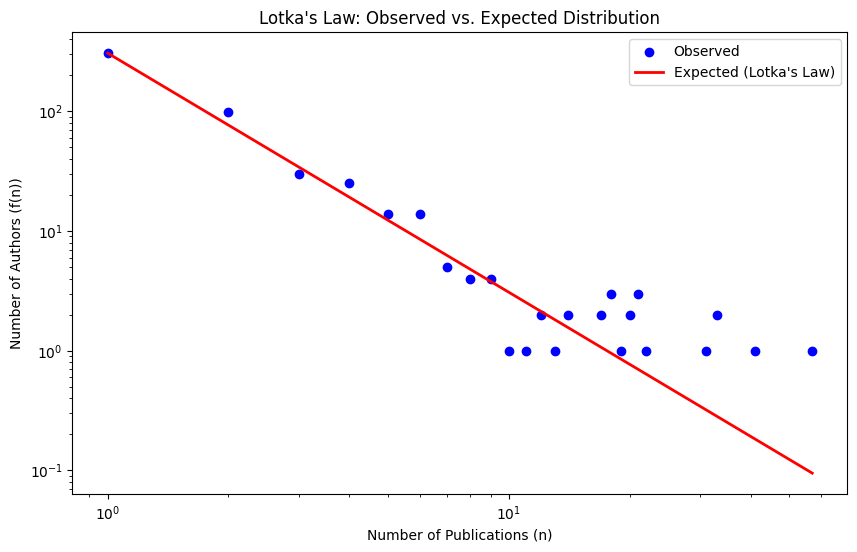

In [99]:
plt.figure(figsize=(10, 6))
plt.scatter(n, observed, color='blue', label='Observed')
plt.plot(n, expected, color='red', label='Expected (Lotka\'s Law)', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Publications (n)')
plt.ylabel('Number of Authors (f(n))')
plt.title('Lotka\'s Law: Observed vs. Expected Distribution')
plt.legend()
plt.savefig('../images/lotkas_law.png', dpi=300)  # Save the figure as a PNG file with 300 dpi

plt.show()

Calculating best minimal value for power law fit
Estimated power law exponent (alpha): 2.6204862975215457
Estimated minimum value for the power law (xmin): 4.0


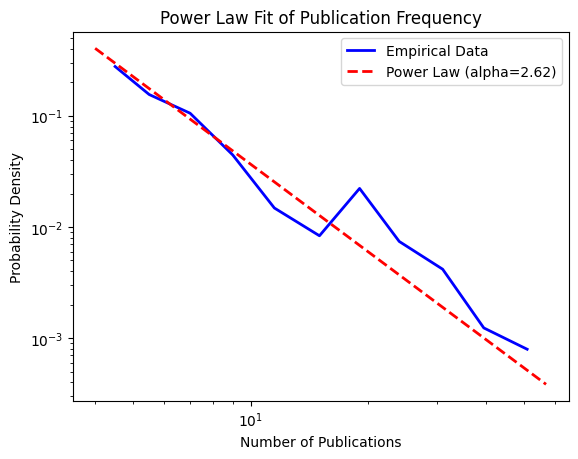

In [101]:
# Assuming `n` contains the number of publications and `observed` contains the frequency

# Repeat each value in `n` according to its frequency in `observed`
data = np.repeat(n, observed)

# Fit the power law to the data
fit = powerlaw.Fit(data)

# Get the estimated alpha (exponent of the power law)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin

print(f"Estimated power law exponent (alpha): {alpha}")
print(f"Estimated minimum value for the power law (xmin): {xmin}")

# Optionally, you can also plot the data and the fitted power law

fig = fit.plot_pdf(color='b', linestyle='-', linewidth=2, label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', linewidth=2, ax=fig, label=f'Power Law (alpha={alpha:.2f})')


# Add titles and labels
plt.title('Power Law Fit of Publication Frequency')
plt.xlabel('Number of Publications')
plt.ylabel('Probability Density')
plt.legend()
plt.savefig('../images/law_estimated_by_powerlaw.png', dpi=300)  # Save the figure as a PNG file with 300 dpi

plt.show()